In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [3]:
import torchvision
import torch
import time
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
from matplotlib import pyplot as plt

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [5]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


# Inference

In [6]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O car.jpg

--2019-07-26 21:23:31--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.208.155
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.208.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2307387 (2.2M) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>]   2.20M  --.-KB/s    in 0.05s   

2019-07-26 21:23:31 (44.0 MB/s) - ‘car.jpg’ saved [2307387/2307387]



In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# select image
im_path = "./car.jpg"
im = Image.open(im_path)

# Defing PyTorch Transform
transform = transforms.Compose([transforms.ToTensor()])

# Apply the transform to the image
im = transform(im)  # .cuda()

model.eval()  # set eval mode
with torch.no_grad():
    start = time.time()
    pred = model([im])
    print(f"Time spend: {time.time() - start}")

In [10]:
def get_bounding_box_from_preds(pred, threshold=0.6):
    pred_labels = list(pred[0]["labels"].cpu().numpy())
    pred_boxes = list(pred[0]["boxes"].detach().cpu().numpy().astype(np.int32))
    pred_scores = list(pred[0]["scores"].cpu().numpy())

    qualified_labels = []
    qualified_boxes = []
    for label, box, score in zip(pred_labels, pred_boxes, pred_scores):
        if score > threshold:
            qualified_labels.append(label)
            qualified_boxes.append(box)
    return qualified_labels, qualified_boxes

In [11]:
def display_annotations(im_path, boxes, labels, categories):
    rect_th = 2
    text_size = 0.8
    text_th = 2
    color = (255, 0, 0)

    # Read image with cv2
    im = cv2.imread(str(im_path))

    # Convert to RGB
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    if len(boxes) > 0:
        for i in range(len(boxes)):

            # reformat boxes to be consumable by cv2
            box = [(boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3])]

            # Draw Rectangle with the coordinates
            cv2.rectangle(
                im, box[0], box[1], color=color, thickness=rect_th
            )

            # Write the prediction class
            cv2.putText(
                im,
                categories[labels[i]],
                box[0],
                cv2.FONT_HERSHEY_SIMPLEX,
                text_size,
                color=color,
                thickness=text_th,
            )

    # display the output image
    plt.figure(figsize=(20, 30))
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    plt.show()

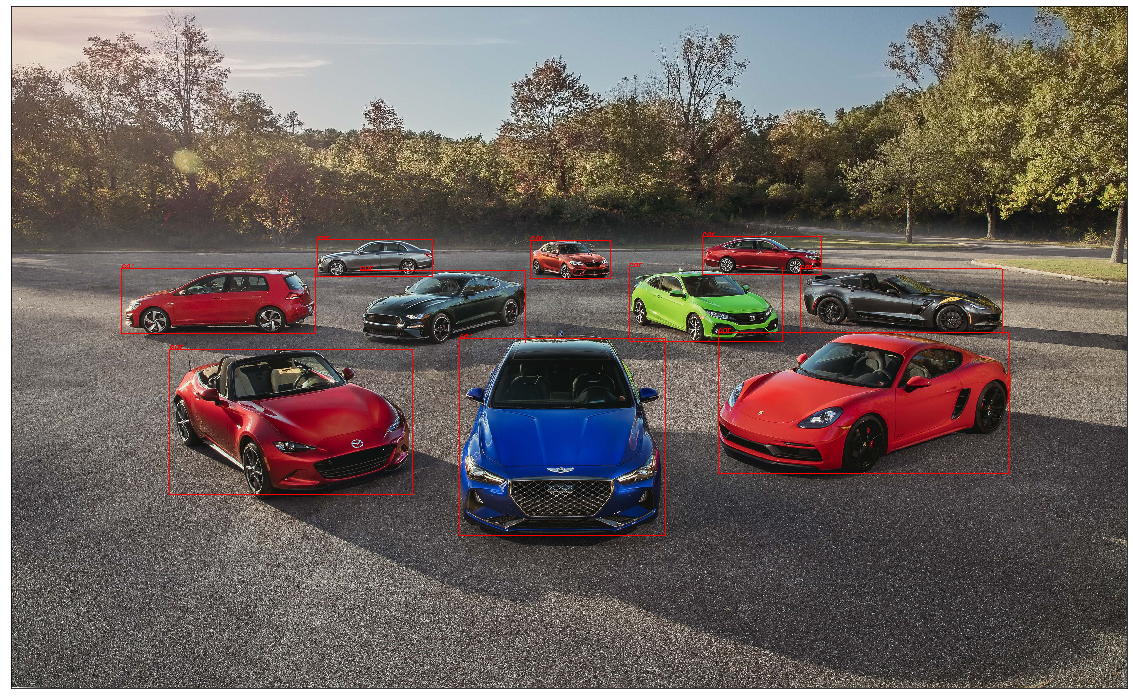

In [12]:
pred_labels, pred_boxes = get_bounding_box_from_preds(pred)
display_annotations(im_path, pred_boxes, pred_labels, COCO_INSTANCE_CATEGORY_NAMES)